# 🐵 End-to-End Multi-Class Face Expression Classification

This notebook builds and end-to-end Face Expression Detection using Keras and CNN's.

## 1. Problem

Identifying the face expression of a human, given an image of him/her.

## 2. Data
  
Data is taken from Kaggle's Facial Expression Recognition Challenge:
https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

Currently the data from above official Kaggle link is not available. So we can take the same data from : https://www.kaggle.com/shawon10/facial-expression-detection-cnn?select=fer2013.csv

## 3. Evaluation

Evaluation is done based on accuracy and loss between predicted expression and actual expression.

## 4. Features

Some information about the data:
* We're dealing with images(unstructured data), so better we use deep learning / transfer learning.
* Data has 3 columns namely emotions, picture, and usage(Training/Testing).
* Data has 35887 rows(images).
* There are 28709 training images (with column value as Training).
* There are 3589 testing images (with column value as PublicTest).
* PrivateTest records are ignored as of now.
* Data has 7 classes (emotions).
  * 0=Angry
  * 1=Disgust
  * 2=Fear
  * 3=Happy
  * 4=Sad
  * 5=Surprise
  * 6=Neutral


In [0]:
# Unzip the uploaded data into google drive
# !unzip "drive/My Drive/Expression Detection/fer2013.csv.zip" -d "drive/My Drive/Expression Detection/"

## Getting our Workspace ready

In [0]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

base_path = "drive/My Drive/Expression Detection/"
%matplotlib inline
# other imports will be done in the appropriate cells whenever necessary

### Check GPU availability

In [3]:
# Check for GPU availability
print("GPU ", "available :) !!" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU  available :) !!


## Getting our data ready

### Importing data into numpy array

In [4]:
raw_df = pd.read_csv("drive/My Drive/Expression Detection/fer2013.csv")
raw_df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


### Exploring data

In [5]:
# Checking for number of columns
raw_df.columns

Index(['emotion', 'pixels', 'Usage'], dtype='object')

In [6]:
# Checking for total number of records and their data_types
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [7]:
# Checking for total number of unique classes
raw_df["emotion"].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [8]:
# Checking for total number of training and testing images
# Total training images:
raw_df[raw_df['Usage'] == "Training"]

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
28704,2,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...,Training
28705,0,114 112 113 113 111 111 112 113 115 113 114 11...,Training
28706,4,74 81 87 89 95 100 98 93 105 120 127 133 146 1...,Training
28707,0,222 227 203 90 86 90 84 77 94 87 99 119 134 14...,Training


In [9]:
# Total testing images:
raw_df[raw_df["Usage"] == "PrivateTest"]

,emotion,pixels,Usage
32298,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...,PrivateTest
32299,5,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...,PrivateTest
32300,6,232 240 241 239 237 235 246 117 24 24 22 13 12...,PrivateTest
32301,4,200 197 149 139 156 89 111 58 62 95 113 117 11...,PrivateTest
32302,2,40 28 33 56 45 33 31 78 152 194 200 186 196 20...,PrivateTest
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [10]:
# Checking total unique values in Usage column
raw_df["Usage"].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

## Creating Training and Test Sets

In [0]:
# X_train = raw_df['pixels'][raw_df["Usage"] == "Training"]
# y_train = raw_df['emotion'][raw_df["Usage"] == "Training"]
# X_test = raw_df['pixels'][raw_df["Usage"] == "PublicTest"]
# y_test= raw_df['emotion'][raw_df["Usage"] == "PublicTest"]
# X_train.shape, y_train.shape, X_test.shape, y_test.shape

### Initialize the total number of classes

In [0]:
# Initialize the total number of classes
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral

### Initialize training and test datasets

In [0]:
# Initialize training and test datasets
X_train, y_train, X_test, y_test = [], [], [], []

In [0]:
# Transform train and test data sets

# Loop through the entire dataframe
for index, row in raw_df.iterrows():
  # transform pixels
  pixels_val = row["pixels"]
  pixels = np.array(pixels_val.split(" "), dtype='float32')

  # transform emotions
  emotion_val = row["emotion"]
  emotion = keras.utils.to_categorical(emotion_val, num_classes=num_classes)

  # Split the data based on usage
  usage = row["Usage"]

  if "Training" in usage:
    X_train.append(pixels)
    y_train.append(emotion)
  elif "PublicTest" in usage:
    X_test.append(pixels)
    y_test.append(emotion)

In [15]:
X_train

[array([ 70.,  80.,  82., ..., 106., 109.,  82.], dtype=float32),
 array([151., 150., 147., ..., 193., 183., 184.], dtype=float32),
 array([231., 212., 156., ...,  88., 110., 152.], dtype=float32),
 array([ 24.,  32.,  36., ..., 142., 143., 142.], dtype=float32),
 array([ 4.,  0.,  0., ..., 30., 29., 30.], dtype=float32),
 array([55., 55., 55., ..., 34., 30., 57.], dtype=float32),
 array([ 20.,  17.,  19., ...,  99., 107., 118.], dtype=float32),
 array([ 77.,  78.,  79., ..., 125.,  67.,  68.], dtype=float32),
 array([85., 84., 90., ..., 58., 73., 84.], dtype=float32),
 array([255., 254., 255., ..., 254., 255., 255.], dtype=float32),
 array([ 30.,  24.,  21., ..., 172., 173., 173.], dtype=float32),
 array([39., 75., 78., ..., 84., 83., 87.], dtype=float32),
 array([219., 213., 206., ...,   0.,   0.,   0.], dtype=float32),
 array([148., 144., 130., ..., 112., 111., 111.], dtype=float32),
 array([ 4.,  2., 13., ...,  3.,  7., 12.], dtype=float32),
 array([107., 107., 109., ...,  83.,  84

In [0]:
# Current training and test data sets are in the form of lists, we need to convert them into arrays

X_train = np.array(X_train, dtype='float32')
y_train = np.array(y_train, dtype='float32')
X_test = np.array(X_test, dtype='float32')
y_test = np.array(y_test, dtype='float32')

In [17]:
X_train

array([[ 70.,  80.,  82., ..., 106., 109.,  82.],
       [151., 150., 147., ..., 193., 183., 184.],
       [231., 212., 156., ...,  88., 110., 152.],
       ...,
       [ 74.,  81.,  87., ..., 188., 187., 187.],
       [222., 227., 203., ..., 136., 136., 134.],
       [195., 199., 205., ...,   6.,  15.,  38.]], dtype=float32)

### Normalize the inputs between [0, 1]

In [0]:
# Normalize the inputs between [0, 1]
X_train /= 255
X_test /= 255

In [19]:
X_train.shape[0]

28709

### Reshape the inputs

In [20]:
# Reshape each value from 1D(28709) to 3D(48,48,1)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_train = X_train.astype('float32')
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)
X_test = X_test.astype('float32')

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

28709 train samples
3589 test samples


In [21]:
X_train.shape

(28709, 48, 48, 1)

### Batichfy the data

Turn the data into batches as our CNN model would accept data in the form of batches.

In [0]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# Turn data to batches
batch_size = 256
gen = ImageDataGenerator()
train_generator = gen.flow(X_train, y_train, batch_size = batch_size)

## Construct a CNN (Convolutional Neural Network)

Here we can start with Keras-Sequential as our base model.

### Create a model

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

model = Sequential()

# 1st Convolutionla layer
model.add(Conv2D(64, (5,5), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(5,5), strides=(2,2)))

# 2nd Convolutionla layer
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2,2)))

# 3rd Convolutionla layer
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Flatten())

# Fully connected Neural Network
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

### Fit the model

In [0]:
# Assign number of epochs for which the model has to be trained
epochs = 30

In [35]:
fit = False

if fit == True:
  # Train the model on the entire data set
  model.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs, verbose=1)

  #Saving the model as a single .hdf5 file
  model.save('drive/My Drive/Expression Detection/model25.hdf5')
else:
  # load weights
  #model.load_weights('drive/My Drive/Expression Detection/facial_expression_model_weights.h5')
  pass


Epoch 1/30
256/256 [==============================] - 5s 21ms/step - loss: 1.7751 - accuracy: 0.2678
Epoch 2/30
256/256 [==============================] - 5s 19ms/step - loss: 1.5263 - accuracy: 0.3995
Epoch 3/30
256/256 [==============================] - 5s 20ms/step - loss: 1.3473 - accuracy: 0.4795
Epoch 4/30
256/256 [==============================] - 5s 20ms/step - loss: 1.2417 - accuracy: 0.5253
Epoch 5/30
256/256 [==============================] - 5s 20ms/step - loss: 1.1678 - accuracy: 0.5563
Epoch 6/30
256/256 [==============================] - 5s 20ms/step - loss: 1.1004 - accuracy: 0.5832
Epoch 7/30
256/256 [==============================] - 5s 20ms/step - loss: 1.0379 - accuracy: 0.6054
Epoch 8/30
256/256 [==============================] - 5s 19ms/step - loss: 0.9689 - accuracy: 0.6332
Epoch 9/30
256/256 [==============================] - 5s 20ms/step - loss: 0.8920 - accuracy: 0.6643
Epoch 10/30
256/256 [==============================] - 5s 19ms/step - loss: 0.8432 - accura

## Saving the model

Save the model as a single .hdf5 file with `model.save()` method

In [0]:
#Saving the model as a single .hdf5 file
#model.save('drive/My Drive/Expression Detection/model25.hdf5')

## Load the saved model

Load the saved model using `load_model()`. The loaded model wil can be directly used of prediction.

In [0]:
loaded_model = keras.models.load_model('drive/My Drive/Expression Detection/model25.hdf5')

## Evaluate the trained model

Use the `evaluate()` method to evalute the trained model against train and test dataset

In [38]:
train_score = loaded_model.evaluate(X_train, y_train, verbose=1)
print(f"Train loss : {train_score[0]}")
print(f"Train accuracy : {train_score[1]}")
test_score = loaded_model.evaluate(X_test, y_test, verbose=1)
print(f"Train loss : {test_score[0]}")
print(f"Train accuracy : {test_score[1]}")

28709/28709 [==============================] - 3s 95us/step
Train loss : 0.08908154552411152
Train accuracy : 0.9706015586853027
3589/3589 [==============================] - 0s 91us/step
Train loss : 3.3263633210667662
Train accuracy : 0.5759264230728149


### Function to analyze and plot the prediction results

In [0]:
def analyze_emotion(emotions):
  label_values = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
  y_seq = np.arange(len(label_values))

  plt.bar(y_seq, emotions, align='center', alpha=0.5)
  plt.xticks(y_seq, labels=label_values)
  plt.ylabel('Percentage')
  plt.title('Emotion')
  plt.show()

## Testing the model with custom(external) data


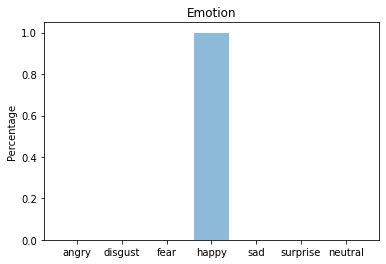

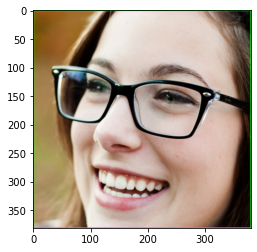

In [106]:
file = "drive/My Drive/Expression Detection/data/capture.jpg"
actual_image = image.load_img(file)
img = image.load_img(file, color_mode='grayscale', target_size=(48,48))

X_custom = image.img_to_array(img)
X_custom = np.expand_dims(X_custom, axis=0)

#normalize the cusotm input
X_custom /= 255

y_custom = loaded_model.predict(X_custom)
analyze_emotion(y_custom[0])


plt.gray()
plt.imshow(actual_image)
plt.show()


### Reduce noise in testing images using openCV2 and Haarcascade model.

Before sending our custom image to the model for prediction, we have to make sure the all the un-necessary part of the image is removed. Haarcascade model with the help of openCV2 automatically detects the face in the model and trims the remaining part. 
Doing so, will make our model less confused and predict well.

Create a function named `face_crop()` which will achieve the above behaviour.

In [0]:
def face_crop(image):
  face_data = base_path + 'haarcascade_frontalface_alt.xml'
  cascade = cv2.CascadeClassifier(face_data)
  img = cv2.imread(image)

  try:
  
    minisize = (img.shape[1], img.shape[0])
    miniframe = cv2.resize(img, minisize)

    faces = cascade.detectMultiScale(miniframe)

    for f in faces:
      x, y, w, h = [v for v in f]
      cv2.rectangle(img, (x,y), (x+w,y+w), (0,255,0), 2)
      sub_face = img[y:y+h, x:x+w]
      cv2.imwrite(base_path+'data/capture.jpg', sub_face)

      #cv2.imwrite(image, sub_face)

  except Exception as e:
    print(e)
  
  print("crop completed.")

  #return sub_face

In [105]:
face_crop(base_path+'data/1.jpg')

crop completed.


In [0]:
#CODE for Capturing an image on Colab from here: https://colab.research.google.com/notebook#fileId=1OnUy6eFE7XhdfGfAHDCqQxpwueTOj_NO

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename=base_path+'data/photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename